# Autoencoders and GANs
Explore how autoencoders work and how to use them for dimensionality reduction, feature extraction, unsupervised pretraining or as generative models. Then, understand adversial training and build a simple GAN to generate fake images.

## What are Autoencoders?
Data around us, like images and documents, are very high dimensions. Autoencoders can learn a simple representation of it. They are a class of "unsupervised" neural networks.

**Encoders** learns the representation, while **decoders** reconstructs from the representation by minimizing the *reconstruction loss function*.

The architecture consists of 3 parts:
1. Encoder
2. A bottleneck
3. Decoder

![Autoencoders Schema](images/autoencoder-architecture.png)
The output consists of a reconstructed input. Hence it has the same dimensions.The objective is to learn a representation that will minimize the reconstruction loss.

If the number of neurons in the hidden layer are less than that of the input layer, the autoencoder is said to be *undercomplete*.

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


A couple utility functions to plot grayscale 28x28 image:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

### PCA with a linear Autoencoder
If the decoder phase does not use the activation function and the cost function is the mean squared error (MSE), then it ends up performing PCA.

In [24]:
# Build 3D dataset:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data
    
X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [25]:
# building an encoder
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([ keras.layers.Dense(2, input_shape=[3]) ])
decoder = keras.models.Sequential([ keras.layers.Dense(3, input_shape=[2]) ])

autoencoder = keras.models.Sequential([encoder, decoder])

# loss = mse and no activation
autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.1))

In [26]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 2ms/step - loss: 0.3019
Epoch 2/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2836
Epoch 3/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2667
Epoch 4/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2520
Epoch 5/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2370
Epoch 6/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2234
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2098
Epoch 8/20
2/2 [==============================] - 0s 3ms/step - loss: 0.1968
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1843
Epoch 10/20
2/2 [==============================] - 0s 3ms/step - loss: 0.1722
Epoch 11/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1605
Epoch 12/20
2/2 [==============================] - 0s 4ms/step - loss: 0.1498
Epoch 13/20
2/2 [==============================] - 0s 2ms/step - loss: 0.

In [27]:
codings = encoder.predict(X_train)

Saving figure linear_autoencoder_pca_plot


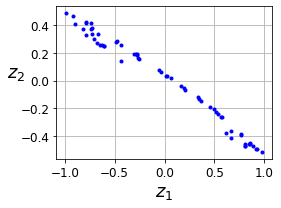

In [29]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

### Stacked Autoencoders
Autoencoders can have multiple hidden layers. Adding more layers help the autoencoder learn more complex codings. The architecture is typically symmetrical with regard to the central hidden layer.

In [30]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [32]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [34]:
# using MNIST data
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), # flatten 28 x 28 image
    keras.layers.Dense(100, activation='selu'), # process through 2 dense layers of diminishing sizes i.e 100 and 30
    keras.layers.Dense(30, activation='selu') # output vector of size 30
])

stacked_decoder = keras.models.Sequential([ 
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(784, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

# we are treating the reconstruction task as multilabel binary classification problem:
stacked_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy]) 

history = stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3354 - rounded_accuracy: 0.8897 - val_loss: 0.3178 - val_rounded_accuracy: 0.8983
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3046 - rounded_accuracy: 0.9161 - val_loss: 0.3015 - val_rounded_accuracy: 0.9217
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2977 - rounded_accuracy: 0.9222 - val_loss: 0.3007 - val_rounded_accuracy: 0.9155
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2937 - rounded_accuracy: 0.9257 - val_loss: 0.2928 - val_rounded_accuracy: 0.9285
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2911 - rounded_accuracy: 0.9280 - val_loss: 0.2908 - val_rounded_accuracy: 0.9291
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2890 - rounded_accuracy: 0.9298 - val_loss: 0.2897 - val_rounded_accuracy: 0.9319
Epoch 7/10
1719/1719 [==================

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [35]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


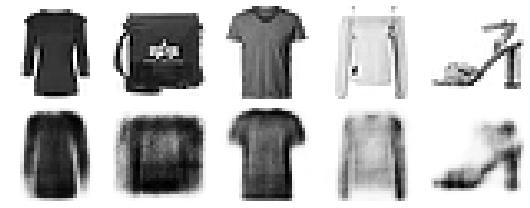

In [37]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

The above model is too lossy. But if we make the network too powerful, it will not learn any useful patterns in data.

### Visualizing the Fashion MNIST Dataset
We first use the encoder from our stacked autoencoder to reduce the dimensionality down to 30, then we use scikit-learns implementation fo t-SNE algorithm to reduce the dimensionality down to 2 for visualization:

In [53]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)

tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

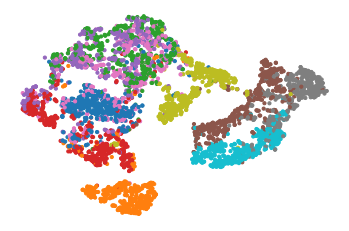

In [55]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap='tab10')
plt.axis("off")
plt.show()

### Tying Weights
*Tying* the weights of the decoder layers to the weights of the encoder layers with reduce the number of weights in the model by half. This speeds up training, limiting the risk of overfitting.

To implement tying weights, we need to create a custom layer to tie weights between the layer using keras. This custom layer acts as a regular dense layer, but it uses the transposed weights of the encoder’s dense layer, however having its own bias vector.

In [60]:
# acts like regular layer, but it uses another Dense layer's weights, transposed
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        # own bias vector
        self.biases = self.add_weight(name='bias', initializer='zeros', shape=self.dense.input_shape[-1])
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b = True)
        # transpose + bias
        return self.activation(z + self.biases)

In [61]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation='selu')
dense_2 = keras.layers.Dense(30, activation='selu')

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1, # 100
    dense_2 # 30
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

In [62]:
tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3261 - rounded_accuracy: 0.8966 - val_loss: 0.3083 - val_rounded_accuracy: 0.9180
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2979 - rounded_accuracy: 0.9218 - val_loss: 0.2949 - val_rounded_accuracy: 0.9262
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2922 - rounded_accuracy: 0.9272 - val_loss: 0.2917 - val_rounded_accuracy: 0.9288
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2894 - rounded_accuracy: 0.9297 - val_loss: 0.2920 - val_rounded_accuracy: 0.9311
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2876 - rounded_accuracy: 0.9313 - val_loss: 0.2905 - val_rounded_accuracy: 0.9264
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2861 - rounded_accuracy: 0.9327 - val_loss: 0.2877 - val_rounded_accuracy: 0.9328
Epoch 7/10
1719/1719 [==================

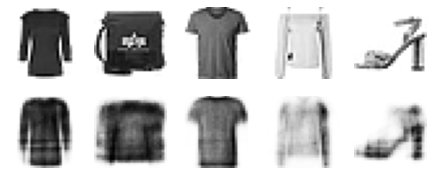

In [63]:
show_reconstructions(tied_ae)
plt.show()

### Convolutional Autoencoders
CNN are far better suited for images. The encoder is composed of convolutional layers and pooling layers. It typically reduces the spatial dimensionality (height and width) of the inputs while increasing the depth (number of feature maps). The decoder reverses this effect using transpose convolutional layers.

In [65]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28,28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, 
                                 padding='valid', activation='selu', input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, 
                                 padding='same', activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, 
                                 padding='same', activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

In [66]:
conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 58s 34ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2852 - val_rounded_accuracy: 0.9279
Epoch 2/5
1719/1719 [==============================] - 54s 31ms/step - loss: 0.2756 - rounded_accuracy: 0.9413 - val_loss: 0.2729 - val_rounded_accuracy: 0.9455
Epoch 3/5
1719/1719 [==============================] - 54s 31ms/step - loss: 0.2708 - rounded_accuracy: 0.9462 - val_loss: 0.2696 - val_rounded_accuracy: 0.9496
Epoch 4/5
1719/1719 [==============================] - 63s 37ms/step - loss: 0.2682 - rounded_accuracy: 0.9489 - val_loss: 0.2685 - val_rounded_accuracy: 0.9492
Epoch 5/5
1719/1719 [==============================] - 58s 34ms/step - loss: 0.2664 - rounded_accuracy: 0.9509 - val_loss: 0.2673 - val_rounded_accuracy: 0.9505


In [67]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)        

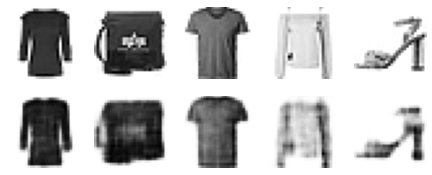

In [68]:
show_reconstructions(conv_ae)
plt.show()

### Recurrent Autoencoders
Autoencoders for sequences such as time series or text. The encoder is typically a sequence-to-vector RNN which compresses the input sequence down to a single vector. The decoder is a vector-to-sequence RNN that does the reverse:

In [70]:
np.random.seed(42)
tf.random.set_seed(42)

recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
    keras.layers.LSTM(30)
])

recurrent_decoder = keras.models.Sequential([
     # RepeatVector ensures that its input vector gets fed to the decoder at each time step
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid'))
])

recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

In [71]:
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 118s 69ms/step - loss: 0.5019 - rounded_accuracy: 0.7689 - val_loss: 0.4505 - val_rounded_accuracy: 0.8224
Epoch 2/10
1719/1719 [==============================] - 110s 64ms/step - loss: 0.4008 - rounded_accuracy: 0.8440 - val_loss: 0.3759 - val_rounded_accuracy: 0.8638
Epoch 3/10
1719/1719 [==============================] - 108s 63ms/step - loss: 0.3677 - rounded_accuracy: 0.8672 - val_loss: 0.3607 - val_rounded_accuracy: 0.8732
Epoch 4/10
1719/1719 [==============================] - 109s 64ms/step - loss: 0.3530 - rounded_accuracy: 0.8780 - val_loss: 0.3555 - val_rounded_accuracy: 0.8738
Epoch 5/10
1719/1719 [==============================] - 109s 63ms/step - loss: 0.3430 - rounded_accuracy: 0.8858 - val_loss: 0.3395 - val_rounded_accuracy: 0.8888
Epoch 6/10
1719/1719 [==============================] - 112s 65ms/step - loss: 0.3355 - rounded_accuracy: 0.8910 - val_loss: 0.3317 - val_rounded_accuracy: 0.8944
Epoch 7/10
1719/1719 [

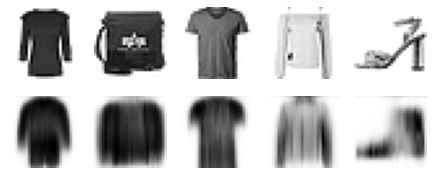

In [72]:
show_reconstructions(recurrent_ae)
plt.show()

### Denoising Autoencoders
Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs.

The implementation is straightforward: it is a regular stacked autoencoder with an additional Dropout layer applied to the encoder's inputs (or you could use a GaussianNoise layer instead).

Using Dropout:

In [80]:
np.random.seed(42)
tf.random.set_seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])

dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(784, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])

In [81]:
dropout_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.0), metrics=[rounded_accuracy])

history = dropout_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3126 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9173
Epoch 7/10
1719/1719 [==================

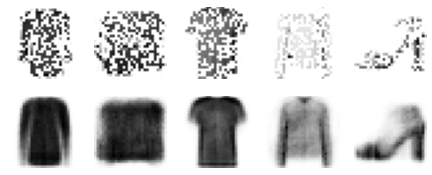

In [82]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
plt.show()

Using GaussianNoise:

In [83]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3499 - rounded_accuracy: 0.8774 - val_loss: 0.3173 - val_rounded_accuracy: 0.9053
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3122 - rounded_accuracy: 0.9095 - val_loss: 0.3086 - val_rounded_accuracy: 0.9122
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3063 - rounded_accuracy: 0.9146 - val_loss: 0.3043 - val_rounded_accuracy: 0.9182
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3028 - rounded_accuracy: 0.9177 - val_loss: 0.3002 - val_rounded_accuracy: 0.9217
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2998 - rounded_accuracy: 0.9203 - val_loss: 0.2976 - val_rounded_accuracy: 0.9238
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2977 - rounded_accuracy: 0.9222 - val_loss: 0.2955 - val_rounded_accuracy: 0.9265
Epoch 7/10
1719/1719 [==================

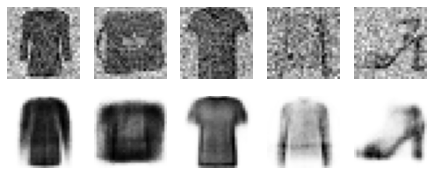

In [84]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

### Sparse Autoencoders
By adding an appropriate term to the cost funciton, the autoencoder is pushed to reduce the number of active neurons in the coding layer. This forces the autoencoder to represent each input as a combination of a small number of activations.

A simple approach is to use the sigmoid activation function in the coding layer, use a large coding layer (e.g., with 300 units), and add some l1 regularization to the coding layer's activation:

In [87]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid'),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])

sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),
    keras.layers.Dense(784, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])

sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4310 - rounded_accuracy: 0.8129 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3690 - rounded_accuracy: 0.8689 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3545 - rounded_accuracy: 0.8799 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3372 - rounded_accuracy: 0.8920 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/10
1719/1719 [==================

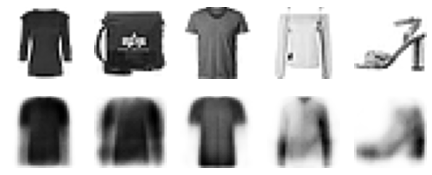

In [88]:
show_reconstructions(sparse_l1_ae)

### Variational Autoencoders
They are *probabalistic autoencoders*, meaning that their outputs are partly determined by chance, even after training.<br>
Instead of forcing the encoder to produce a single encoding, it forces the encoder to produce a probability distribution. The decoder will then sample an encoding from that probability distribution, and try to reconstruct the original input.

They are *generative autoencoders*, meaning that they can generate new instances that look like they were sampled from the training set.

##### How they work?
* The encoder and decoder have 2 hidden layers.
* Instead of directly producing a coding for a given input, the encoder produces a *mean* **$\mu$** and a *standard deviation* **$\sigma$**.
* After that the decoder decodes the sampled coding normally.

![VAE](images/VAE_complete.png)

The cost function is composed of two parts:
* The first is the *reconstruction loss* that pushes the autoencoder to reproduce its inputs (we can use cross entropy).
* The second is *latent loss* that pushes the autoencoder to have codings that look as though they were sampled from a simple Gaussian distribution (KL divergence between target distribution).

Variational Autoencoder's latent loss, rewritten using $\gamma=log(\sigma^2)$

Latent loss = $\frac{-1}{2}\sum_{i=1}^{K}1+ \gamma_i - exp(\gamma_i) - \mu^2 $.

##### Variational Autoencoder for Fashion MNIST:
We need a custom layer to sample codings, $\mu$ and $\gamma$:

In [98]:
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs): # Sampling layer takes 2 inputs: mean and log_var
        mean, log_var = inputs 
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var/2) + mean # K.exp(log_var/2) is equal
                                                                            # to standard deviation

In [104]:
tf.random.set_seed(42)
np.random.seed(42)

# encoder (below encoder is build using Functional API)
codings_size = 10

inputs = keras.layers.Input(shape=[28,28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation='selu')(z)
z = keras.layers.Dense(100, activation='selu')(z)
codings_mean = keras.layers.Dense(codings_size)(z) # mean
codings_log_var = keras.layers.Dense(codings_size)(z) # standard deviation

codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# decoder
# variational_decoder = keras.models.Sequential([
#     keras.layers.Dense(100, activation='selu', input_shape=[codings_size]),
#     keras.layers.Dense(150, activation='selu'),
#     keras.layers.Dense(784, activation='sigmoid'),
#     keras.layers.Reshape([28,28])
# ])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation='selu')(decoder_inputs)
x = keras.layers.Dense(150, activation='selu')(x)
x = keras.layers.Dense(784, activation='sigmoid')(x)
outputs = keras.layers.Reshape([28,28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])
    
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)

variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

adding the latent loss and the reconstruction loss we get:

In [105]:
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)

variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 7s 15ms/step - loss: 0.3895 - rounded_accuracy: 0.8609 - val_loss: 0.3486 - val_rounded_accuracy: 0.8941
Epoch 2/25
430/430 [==============================] - 6s 14ms/step - loss: 0.3423 - rounded_accuracy: 0.8982 - val_loss: 0.3406 - val_rounded_accuracy: 0.9034
Epoch 3/25
430/430 [==============================] - 6s 13ms/step - loss: 0.3325 - rounded_accuracy: 0.9055 - val_loss: 0.3326 - val_rounded_accuracy: 0.9083
Epoch 4/25
430/430 [==============================] - 6s 13ms/step - loss: 0.3277 - rounded_accuracy: 0.9093 - val_loss: 0.3266 - val_rounded_accuracy: 0.9126
Epoch 5/25
430/430 [==============================] - 6s 13ms/step - loss: 0.3247 - rounded_accuracy: 0.9118 - val_loss: 0.3267 - val_rounded_accuracy: 0.9123
Epoch 6/25
430/430 [==============================] - 6s 14ms/step - loss: 0.3225 - rounded_accuracy: 0.9137 - val_loss: 0.3245 - val_rounded_accuracy: 0.9134
Epoch 7/25
430/430 [==========================

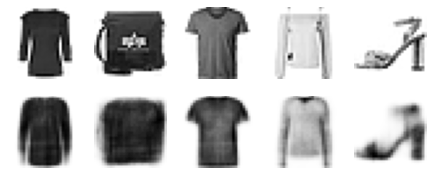

In [106]:
show_reconstructions(variational_ae)
plt.show()

#### Generating Fashion MNIST Images

In [109]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Saving figure vae_generated_images_plot


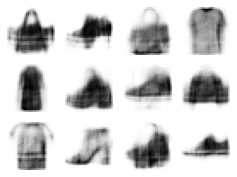

In [112]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])

images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Now let's perform semantic interpolation between these images:

Saving figure semantic_interpolation_plot


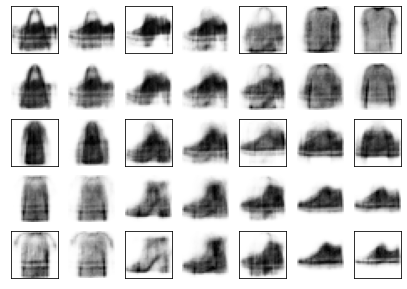

In [113]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

The original images are framed, and the rest are the result of semantic interpolation between nearby images.

## Generative Adversarial Networks